In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Dataloading

---

In [14]:
from helpers.dataset import InpaintingDataset
from helpers import data_utils
from omegaconf import OmegaConf

In [ ]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

diffuse_img, partial_img = data_utils.channels_last(diffuse_img), data_utils.channels_last(partial_img)
diffuse_img, partial_img = data_utils.denormalise_image(diffuse_img), data_utils.denormalise_image(partial_img)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(diffuse_img)
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(partial_img)
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

### Vae encoding and decoding

---

In [ ]:
import os
import torch
from diffusers import AutoencoderKL

from omegaconf import OmegaConf
from helpers.dataset import InpaintingDataset

from matplotlib import pyplot as plt
from helpers import data_utils

In [ ]:
path_to_config = "/home/cizinsky/garment-texture-completion/configs/train.yaml"
with open(path_to_config, "r") as f:
    cfg = OmegaConf.load(f)

vae_path = os.path.join(cfg.model.vae_path, "refine_vae")
vae_diffuse = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae_checkpoint_diffuse",
    revision="fp32",
    local_files_only=True,
    torch_dtype=torch.float32,
).to("cuda").eval()

dataset = InpaintingDataset(cfg)


sample = dataset[0]
diffuse_img, partial_img = sample["full_diffuse_img"][None], sample["partial_diffuse_img"][None]
diffuse_img.shape, partial_img.shape

In [ ]:
tmp_diffuse_img, tmp_partial_img = data_utils.channels_last(diffuse_img), data_utils.channels_last(partial_img)
tmp_diffuse_img, tmp_partial_img = data_utils.denormalise_image(tmp_diffuse_img), data_utils.denormalise_image(tmp_partial_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(tmp_diffuse_img.squeeze(0))
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(tmp_partial_img.squeeze(0))
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

In [12]:
def encode_decode_image(image, vae):
    # Encode
    with torch.no_grad():
        latents = vae.encode(image.cuda()).latent_dist.sample()
        latents = latents * vae.config.scaling_factor  # scale to match diffusion training

    # Decode
    with torch.no_grad():
        decoded = vae.decode(latents / vae.config.scaling_factor).sample

    return decoded

def post_process_image(image):
    decoded_image = data_utils.channels_last(data_utils.denormalise_image(image.cpu().numpy()))
    return decoded_image

In [ ]:
tensor_full, tensor_partial = torch.from_numpy(diffuse_img), torch.from_numpy(partial_img)
decoded_full, decoded_partial = encode_decode_image(tensor_full, vae_diffuse), encode_decode_image(tensor_partial, vae_diffuse)
decoded_full, decoded_partial = post_process_image(decoded_full), post_process_image(decoded_partial)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(decoded_full[0])
ax[0].set_title("Decoded Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(decoded_partial[0])
ax[1].set_title("Decoded Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

### Inference

---

In [42]:
from helpers.dataset import InpaintingDataset
from helpers.pl_module import GarmentInpainterModule
from helpers.data_utils import post_process_image

from omegaconf import OmegaConf
from matplotlib import pyplot as plt

import torch

In [6]:
cfg = OmegaConf.load("../configs/train.yaml")

In [40]:
model = GarmentInpainterModule(cfg, None, None).to("cuda").to(torch.float16).eval()
model.setup()

In [44]:
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

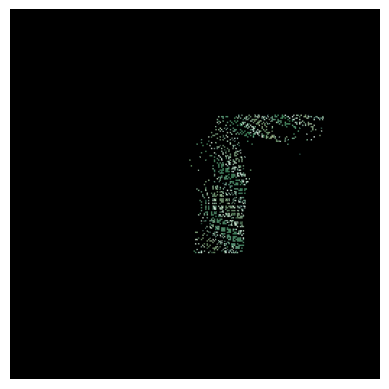

In [45]:
image = partial_img
post_img = post_process_image(image)

plt.imshow(post_img)
plt.axis("off")
plt.show()

In [46]:
x_in = torch.from_numpy(image).unsqueeze(0)
strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
post_inpainted_imgs = []
for strength in strengths:
    inpainted_img = model.inference(x_in.cuda(), strength=strength, num_inference_steps=100)
    post_inpainted_imgs.append(post_process_image(inpainted_img.to(torch.float32)))

100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


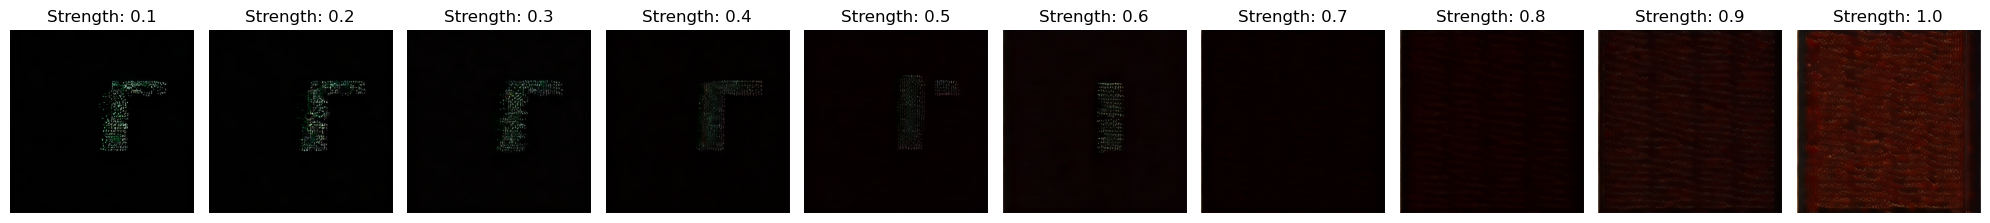

In [47]:
fig, ax = plt.subplots(1, len(strengths), figsize=(20, 5))
for i, post_inpainted_img in enumerate(post_inpainted_imgs):
    ax[i].imshow(post_inpainted_img[0])
    ax[i].axis("off")
    ax[i].set_title(f"Strength: {strengths[i]}")
plt.tight_layout()
plt.show()

### Metrics Computation

---

In [46]:
from helpers.dataset import InpaintingDataset
from helpers.pl_module import GarmentInpainterModule
from helpers.data_utils import post_process_image, denormalise_image
from helpers.metrics import compute_ssim, compute_psnr, compute_lpips, compute_all_metrics

from omegaconf import OmegaConf
import torch

In [4]:
cfg = OmegaConf.load("../configs/train.yaml")

In [5]:
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

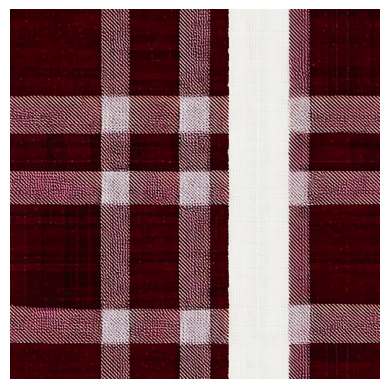

In [8]:
image = diffuse_img
post_img = post_process_image(image)

plt.imshow(post_img)
plt.axis("off")
plt.show()

In [12]:
# B x C x H x W
diffuse_img.shape, diffuse_img.min(), diffuse_img.max()

((3, 512, 512), -1.0, 1.0)

In [18]:
diffuse_img_denormalised = torch.from_numpy(denormalise_image(diffuse_img)).unsqueeze(0)
diffuse_img_denormalised.shape, diffuse_img_denormalised.min(), diffuse_img_denormalised.max()

(torch.Size([1, 3, 512, 512]), tensor(0.), tensor(1.))

In [23]:
lpips = compute_lpips(diffuse_img_denormalised, diffuse_img_denormalised)
ssim = compute_ssim(diffuse_img_denormalised, diffuse_img_denormalised)
psnr = compute_psnr(diffuse_img_denormalised, diffuse_img_denormalised)

print(f"LPIPS: {lpips}, SSIM: {ssim}, PSNR: {psnr}")

LPIPS: 0.0, SSIM: 1.0, PSNR: inf


In [42]:
tiny_noise = torch.randn(diffuse_img_denormalised.shape)
lpips = compute_lpips(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)
ssim = compute_ssim(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)
psnr = compute_psnr(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)

print(f"LPIPS: {lpips}, SSIM: {ssim}, PSNR: {psnr}")

LPIPS: 1.1052637100219727, SSIM: 0.04523353651165962, PSNR: 0.005107455886900425


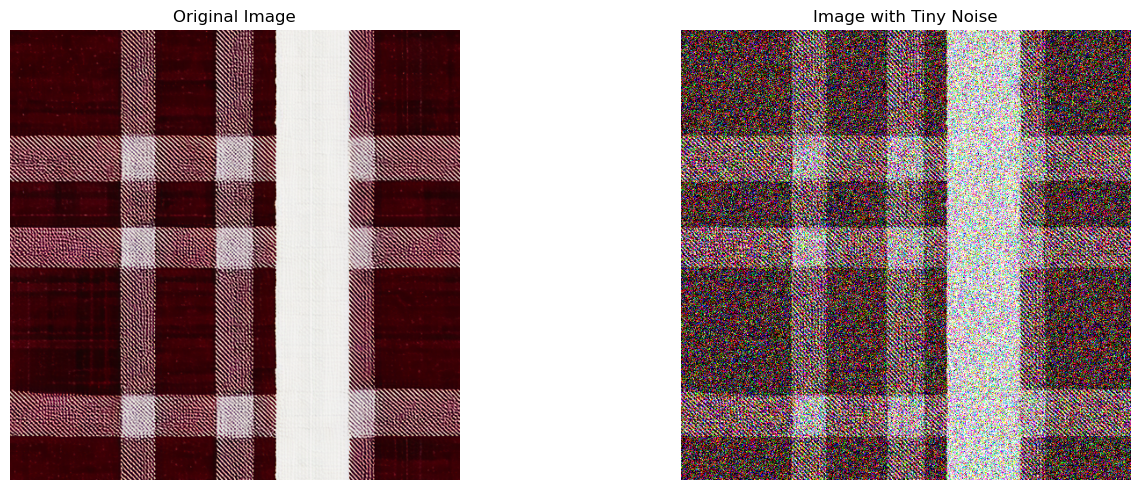

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

post_img = post_process_image(diffuse_img)
ax[0].imshow(post_img)
ax[0].axis("off")
ax[0].set_title("Original Image")

tiny_noise_arr = tiny_noise.cpu().numpy()[0]
post_img_with_noise = post_process_image(diffuse_img + tiny_noise_arr)
ax[1].imshow(post_img_with_noise)
ax[1].axis("off")
ax[1].set_title("Image with Tiny Noise")

plt.tight_layout()
plt.show()

In [45]:
model = GarmentInpainterModule(cfg, None, None).to("cuda").to(torch.float16).eval()
model.setup()

100%|██████████| 10/10 [00:00<00:00, 18.73it/s]


100%|██████████| 50/50 [00:02<00:00, 18.34it/s]


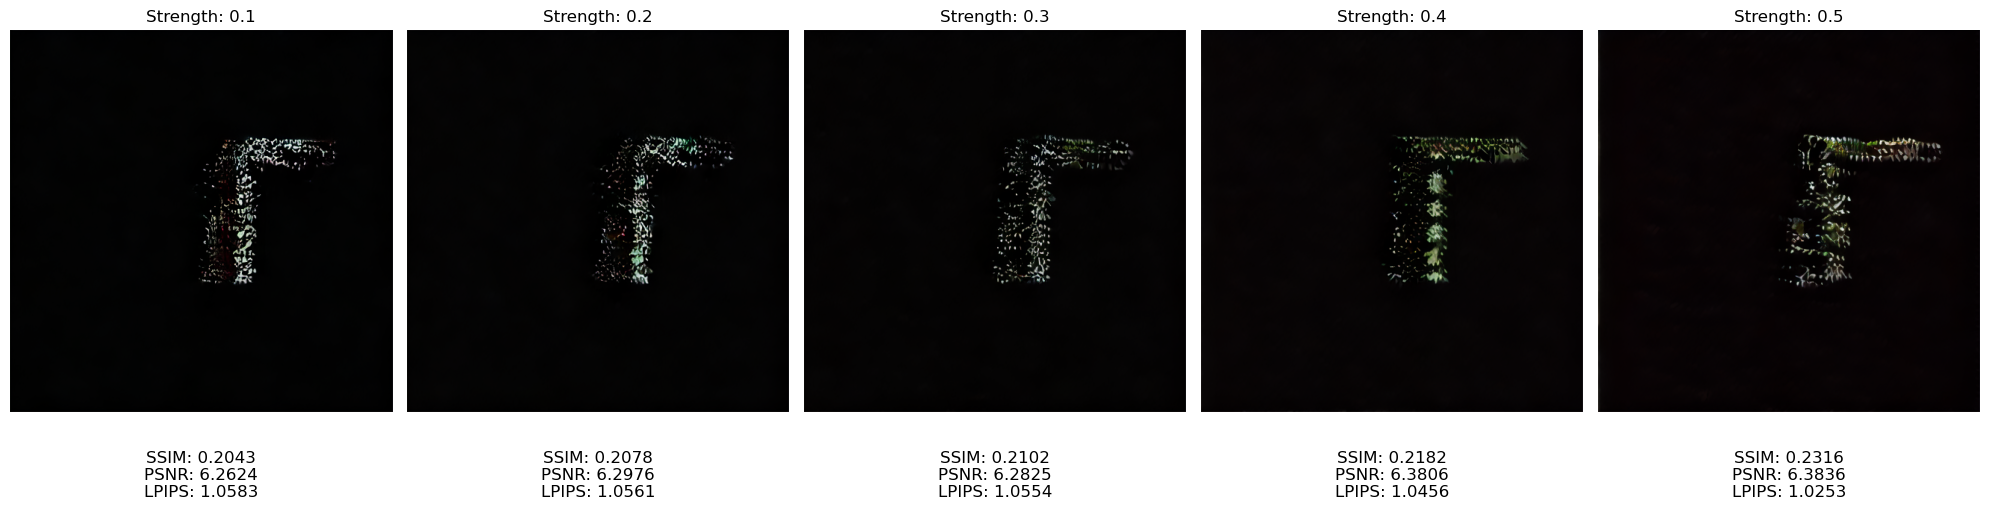

In [53]:
x_in = torch.from_numpy(partial_img).unsqueeze(0)
denorm_full_img = torch.from_numpy(denormalise_image(diffuse_img)).unsqueeze(0)
strengths = [0.1, 0.2, 0.3, 0.4, 0.5]
post_inpainted_imgs = []
metrics = []
for strength in strengths:
    inpainted_img = model.inference(x_in.cuda(), strength=strength, num_inference_steps=100)
    post_inpainted_imgs.append(post_process_image(inpainted_img.to(torch.float32)))

    denorm_inpainted_img = torch.from_numpy(denormalise_image(inpainted_img.to(torch.float32).cpu().numpy()))
    metrics.append(compute_all_metrics(denorm_inpainted_img, denorm_full_img))

fig, ax = plt.subplots(1, len(strengths), figsize=(20, 5))
for i, post_inpainted_img in enumerate(post_inpainted_imgs):
    metrics_dict = metrics[i]
    ax[i].imshow(post_inpainted_img[0])
    ax[i].axis("off")
    ax[i].set_title(f"Strength: {strengths[i]}")
    ax[i].text(0.5, -0.1, f"SSIM: {metrics_dict['ssim']:.4f}\nPSNR: {metrics_dict['psnr']:.4f}\nLPIPS: {metrics_dict['lpips']:.4f}",
               ha='center', va='top', transform=ax[i].transAxes, fontsize=12)

plt.tight_layout()
plt.show()
